# **Load Data von Google- Drive**


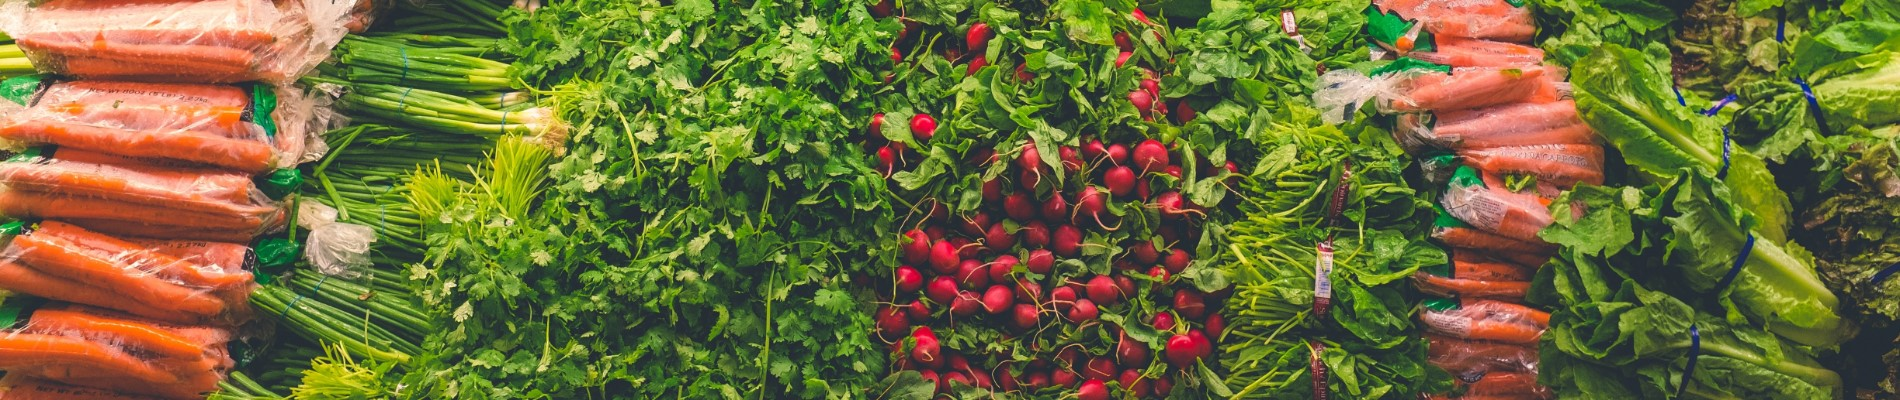


This notebook sets up the complete data ingestion workflow for the **Corporación Favorita Grocery Sales Forecasting** project.  
Our goal is to build a **clean, reproducible, and scalable** environment for time‑series forecasting using both classical ML models and deep learning architectures such as LSTMs.

We will:

- Download all **six raw datasets** required for the challenge
- Verify that everything is stored correctly and ready for analysis
- Summarize the **role of each dataset** in the forecasting problem

By the end of this notebook, we’ll have a solid foundation for the next step: **Exploratory Data Analysis (EDA)**.


## **1️⃣ Projekt Root Path Initialisieren**




This utility script dynamically detects the project’s root directory and adds it to Python’s import path. It ensures that notebooks, scripts, and development utilities can reliably import internal modules without manually modifying `sys.path`.

### 🔍 What This Script Does

- Identifies the current working directory  
- Resolves the project root relative to the script/notebook location  
- Injects the root directory into `sys.path` if missing  
- Enables clean imports such as:

```python
from paths import notebook_dir, _path_dict
```

### 🧠 Why This Matters

In multi‑module projects like **retail_demand_analysis**, imports often break when running:

- Jupyter notebooks  
- Standalone scripts  
- CLI utilities  
- Streamlit pages  

This initializer guarantees consistent module resolution across all environments.




In [31]:
# Pandas-Bibliothek für Datenanalyse und DataFrames importieren
import pandas as pd

# Betriebssystem-spezifische Funktionen für Dateipfad-Operationen importieren
import os

# System-spezifische Parameter und Funktionen für Python-Interpreter importieren
import sys

# Modul für objektorientierte Dateipfad-Behandlung importieren
from pathlib import Path

# Den Python-Pfad um das Projektroot-Verzeichnis erweitern
# 1️⃣ Projektroot-Verzeichnis dynamisch bestimmen

# Aktuelles Arbeitsverzeichnis des Python-Skripts abrufen
cwd = os.getcwd()

# Aktuelles Arbeitsverzeichnis zur Fehlerdiagnose ausgeben
print("1️⃣:Current working directory:", cwd)

# DREI Verzeichnisebenen nach oben navigieren, um retail_demand_analysis zu erreichen
# os.path.join kombiniert Pfadkomponenten, os.path.abspath erzeugt absoluten Pfad
project_root = os.path.abspath(os.path.join(cwd, ".."))

# Bestimmtes Projektroot-Verzeichnis zur Überprüfung ausgeben
print("Project root✅:", project_root)

# 2️⃣ Projektroot-Verzeichnis zum sys.path hinzufügen

# Prüfen, ob Projektroot noch nicht im Python-Pfad enthalten ist
if project_root not in sys.path:
     # Projektroot am Anfang des sys.path-Arrays einfügen für höchste Import-Priorität
     sys.path.insert(0, project_root)

# Bestätigung der erfolgreichen Pfaderweiterung ausgeben
print("2️⃣:Project root added to sys.path:", project_root)

1️⃣:Current working directory: /Users/sadiqqais/Masterschool/Projekt/time_series_projekt/notebooks
Project root✅: /Users/sadiqqais/Masterschool/Projekt/time_series_projekt
2️⃣:Project root added to sys.path: /Users/sadiqqais/Masterschool/Projekt/time_series_projekt


In [32]:
# Import der get_path-Funktion aus dem lokalen paths-Modul
# Diese Funktion ermöglicht den zentralisierten Zugriff auf Projektverzeichnisse
from paths import get_path

# Basisverzeichnis des gesamten Projekts abrufen
# 'root' ist der Schlüssel für das Hauptprojektverzeichnis im Pfad-Dictionary
# Dieses Verzeichnis ist der Ausgangspunkt für alle anderen Pfade im Projekt
BASE_DIR = get_path('root')

# Verzeichnis für Rohdaten abrufen
# 'raw' ist der Schlüssel für das Verzeichnis mit unverarbeiteten Originaldaten
# Diese Daten werden direkt aus den Quellen geladen und nicht modifiziert
RAW_DIR = get_path('raw')

## 2️⃣ Define Google Drive File IDs

Organize dataset identifiers for reproducible downloads.


The raw datasets are stored in Google Drive and identified by unique **file IDs**.  
Instead of hard-coding full URLs everywhere, we centralize these IDs in a single dictionary.

This makes the download logic **transparent and easy to update** if file locations change.


In [33]:
# Dictionary (Wörterbuch) von Datei-IDs für mehr Klarheit
# Ein Dictionary ist eine Sammlung von Schlüssel-Wert-Paaren
# Hier: Dateiname (Schlüssel) -> Google Drive Datei-ID (Wert)
file_ids = {
    # "Ferien-Ereignisse" Datensatz
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",

    # "Artikel" Datensatz - Informationen zu verkauften Produkten
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",

    # "Öl-Preise" Datensatz - historische Ölpreisdaten
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",

    # "Geschäfte" Datensatz - Informationen zu den Filialen
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",

    # "Trainingsdaten" - Hauptdatensatz mit Verkaufszahlen
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",

    # "Transaktionen" - Datensatz mit Verkaufstransaktionen
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

## 3️⃣ Create Direct Download URLs

Generate Google Drive download links from file IDs.


Given a file ID, we can construct a direct download URL that works nicely with Python's HTTP tools or `gdown`.  
To keep things tidy, we wrap this logic in a small helper function.

This function becomes the bridge between our **file ID registry** and the actual download process.


In [34]:
# Importiere benötigte Bibliotheken
import os        # Für Dateisystem-Operationen
import io        # Für In-Memory Datei-Operationen (Bytes/Strings)
import requests  # Für HTTP-Anfragen (Dateien aus dem Internet laden)
import pandas as pd  # Für Datenverarbeitung (DataFrames)

# Funktion zum Erstellen eines direkten Download-Links aus einer Google Drive Datei-ID
def make_drive_url(file_id: str) -> str:
    """
    Erstellt einen direkten Download-Link für eine Google Drive Datei.

    Parameter:
    file_id (str): Die eindeutige Google Drive Datei-ID

    Rückgabe:
    str: Der direkte Download-Link

    Beispiel:
    >>> make_drive_url("1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH")
    'https://drive.google.com/uc?id=1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH'
    """
    # f-String formatiert die URL mit der Datei-ID
    # 'uc' steht für 'user content' - der direkte Download-Endpunkt
    return f"https://drive.google.com/uc?id={file_id}"

## 4️⃣ Download and Save Raw Data to `data/raw/`


### **4.1 Download and saave to data/raw**


With the helper in place, we now download each of the smaller metadata and external context files:

- `holiday_events.csv`
- `items.csv`
- `oil.csv`
- `stores.csv`
- `transactions.csv`

For each file, we:

- Build the download URL from its file ID,
- Save it under `data/raw`, and
- Display a small sample to confirm that the content looks reasonable.


In [35]:
# Installiert gdown für Google Drive-Downloads (Colab-spezifischer Befehl)
# In normalen Python-Umgebungen würde man stattdessen "pip install gdown" verwenden
%pip install gdown
import gdown  # Versuche gdown zu importieren

# Importiere benötigte Bibliotheken für Datenverarbeitung und Download
import io        # Für In-Memory-Dateioperationen (wird hier indirekt genutzt)
import requests  # Für HTTP-Anfragen zum Datei-Download von Standard-URLs
from IPython.display import display  # Für bessere Darstellung in Jupyter Notebooks

# Stelle sicher, dass gdown installiert ist
# gdown ist speziell für große Google-Drive-Dateien optimiert
try:
    import gdown  # Versuche gdown zu importieren
except ImportError:
    # Falls nicht installiert: Installiere gdown und importiere es danach
    # Anmerkung: In Jupyter Notebooks wird dieser Code ausgeführt
    # In normalen Skripten müsste man subprocess verwenden
 def load_csv_from_url(
    url: str,
    filename: str,
    base_dir: str = BASE_DIR,
    raw_subdir: str = RAW_DIR,
    use_gdown: bool = False
) -> pd.DataFrame:
    """
    Lädt eine CSV-Datei von einer URL (oder Google Drive), speichert sie lokal
    im data/raw-Verzeichnis und gibt sie als pandas DataFrame zurück.
    
    Parameter:
    ----------
    url : str
        Direkter Download-Link (kann Google Drive Link sein).
    filename : str
        Name der CSV-Datei zum Speichern (z.B. "sales.csv").
    base_dir : str
        Haupt-Projektverzeichnis (Standard: BASE_DIR aus vorheriger Zelle).
    raw_subdir : str
        Unterverzeichnis für Rohdatenspeicherung (Standard: RAW_DIR).
    use_gdown : bool
        Wenn True, verwende gdown (notwendig für große Google Drive Dateien).
    
    Rückgabe:
    --------
    pd.DataFrame
        Geladener DataFrame mit den Daten aus der CSV-Datei.
    
    Hinweise:
    --------
    - Für Google Drive Links muss `use_gdown=True` gesetzt werden
    - Für normale HTTP-Downloads kann `use_gdown=False` bleiben
    - Die Datei wird im `raw_subdir` gespeichert und bei erneuten Aufrufen wiederverwendet
    """
    # Erstelle den vollständigen Pfad zum raw-Verzeichnis
    # Kombiniert Basisverzeichnis mit Raw-Unterverzeichnis
    raw_dir = os.path.join(base_dir, raw_subdir)
    
    # Stelle sicher, dass das Verzeichnis existiert
    # exist_ok=True verhindert Fehler, falls Verzeichnis bereits existiert
    os.makedirs(raw_dir, exist_ok=True)
    
    # Vollständigen Dateipfad erstellen
    file_path = os.path.join(raw_dir, filename)
    
    # Prüfen, ob die Datei bereits existiert (Caching-Mechanismus)
    if os.path.exists(file_path):
        print(f"📁 Datei bereits vorhanden: {file_path}")
        print("   Verwende lokale Kopie...")
    else:
        # Download-Methode basierend auf use_gdown Parameter wählen
        if use_gdown:
            # Verwende gdown für Google Drive Dateien
            print(f"⬇️ Lade '{filename}' mit gdown herunter...")
            # quiet=False zeigt Fortschrittsbalken während des Downloads
            gdown.download(url, file_path, quiet=False)
        else:
            # Standard HTTP-Download mit requests
            print(f"⬇️ Lade '{filename}' via requests herunter...")
            
            # stream=True für effizienten Download großer Dateien
            # Verhindert, dass die gesamte Datei auf einmal in den Speicher geladen wird
            response = requests.get(url, stream=True)
            
            # Wirft eine Exception bei HTTP-Fehlern (z.B. 404 Not Found)
            response.raise_for_status()
            
            # Speichere die Datei lokal
            # Verwende 'wb' (write binary) für binäre Daten
            with open(file_path, "wb") as f:
                # Schreibe den Inhalt der Response in die Datei
                # response.content enthält die binären Daten
                f.write(response.content)
        
        print(f"✅ Datei erfolgreich gespeichert unter: {file_path}\n")
    
    # Lade die CSV-Datei in einen pandas DataFrame
    try:
        # pd.read_csv() liest die CSV-Datei und konvertiert sie in ein DataFrame
        df = pd.read_csv(file_path)
        
        # Ausgabe von Metadaten über das geladene Dataset
        print(
            f"📊 Dataset geladen: '{filename}' | "
            f"Zeilen: {len(df):,} | Spalten: {df.shape[1]}\n"
        )
        
        # Zeige eine zufällige Stichprobe der Daten an (max. 10 Zeilen)
        # display() ist eine Jupyter-spezifische Funktion für bessere Darstellung
        display(df.sample(n=min(10, len(df))))
    
    except pd.errors.EmptyDataError:
        # Behandlung von leeren oder nicht parsbaren CSV-Dateien
        print(f"⚠️ Warnung: '{filename}' ist leer oder konnte nicht gelesen werden.")
        df = pd.DataFrame()  # Leeres DataFrame zurückgeben
    
    except Exception as e:
        # Allgemeine Fehlerbehandlung für andere Leseprobleme
        print(f"❌ Fehler beim Lesen der Datei: {e}")
        df = pd.DataFrame()
    
    return df

Note: you may need to restart the kernel to use updated packages.


In [36]:
# Importiere benötigte Bibliotheken für Dateioperationen, HTTP-Downloads und Datenverarbeitung
import os        # Für Dateisystem-Operationen und Pfadverwaltung
import io        # Für In-Memory-Dateioperationen (wird hier indirekt genutzt)
import requests  # Für HTTP-Anfragen zum Datei-Download von Standard-URLs
import pandas as pd  # Hauptbibliothek für Datenverarbeitung und -analyse
from IPython.display import display  # Für bessere Darstellung in Jupyter Notebooks

def load_csv_from_url(
    url: str,
    filename: str,
    base_dir: str = BASE_DIR,
    raw_subdir: str = RAW_DIR,
    use_gdown: bool = False
) -> pd.DataFrame:
    """
    Lädt eine CSV-Datei von einer URL (oder Google Drive), speichert sie lokal
    im data/raw-Verzeichnis und gibt sie als pandas DataFrame zurück.
    
    Parameter:
    ----------
    url : str
        Direkter Download-Link (kann Google Drive Link sein).
    filename : str
        Name der CSV-Datei zum Speichern (z.B. "sales.csv").
    base_dir : str
        Haupt-Projektverzeichnis (Standard: BASE_DIR aus vorheriger Zelle).
    raw_subdir : str
        Unterverzeichnis für Rohdatenspeicherung (Standard: RAW_DIR).
    use_gdown : bool
        Wenn True, verwende gdown (notwendig für große Google Drive Dateien).
    
    Rückgabe:
    --------
    pd.DataFrame
        Geladener DataFrame mit den Daten aus der CSV-Datei.
    
    Hinweise:
    --------
    - Für Google Drive Links muss `use_gdown=True` gesetzt werden
    - Für normale HTTP-Downloads kann `use_gdown=False` bleiben
    - Die Datei wird im `raw_subdir` gespeichert und bei erneuten Aufrufen wiederverwendet
    """
    # Erstelle den vollständigen Pfad zum raw-Verzeichnis
    # Kombiniert Basisverzeichnis mit Raw-Unterverzeichnis
    raw_dir = os.path.join(base_dir, raw_subdir)
    
    # Stelle sicher, dass das Verzeichnis existiert
    # exist_ok=True verhindert Fehler, falls Verzeichnis bereits existiert
    os.makedirs(raw_dir, exist_ok=True)
    
    # Vollständigen Dateipfad erstellen
    file_path = os.path.join(raw_dir, filename)
    
    # Prüfen, ob die Datei bereits existiert (Caching-Mechanismus)
    if os.path.exists(file_path):
        print(f"📁 Datei bereits vorhanden: {file_path}")
        print("   Verwende lokale Kopie...")
    else:
        # Download-Methode basierend auf use_gdown Parameter wählen
        if use_gdown:
            # Verwende gdown für Google Drive Dateien
            print(f"⬇️ Downloading '{filename}' using gdown...")
            # quiet=False zeigt Fortschrittsbalken während des Downloads
            # Achtung: gdown muss im Skript vorher importiert werden
            import gdown
            gdown.download(url, file_path, quiet=False)
        else:
            # Standard HTTP-Download mit requests
            print(f"⬇️ Downloading '{filename}' via requests...")
            
            # stream=True für effizienten Download großer Dateien
            # Verhindert, dass die gesamte Datei auf einmal in den Speicher geladen wird
            response = requests.get(url, stream=True)
            
            # Wirft eine Exception bei HTTP-Fehlern (z.B. 404 Not Found)
            response.raise_for_status()
            
            # Speichere die Datei lokal
            # Verwende 'w' mit UTF-8 Encoding für Textdateien
            # Für binäre Daten würde man 'wb' und response.content verwenden
            with open(file_path, "w", encoding="utf-8") as f:
                # Schreibe den Textinhalt der Response in die Datei
                # response.text enthält den dekodierten Textinhalt
                f.write(response.text)
        
        print(f"✅ File successfully saved to: {file_path}\n")
    
    # Lade die CSV-Datei in einen pandas DataFrame
    try:
        # pd.read_csv() liest die CSV-Datei und konvertiert sie in ein DataFrame
        df = pd.read_csv(file_path)
        
        # Ausgabe von Metadaten über das geladene Dataset
        print(
            f"📊 Dataset loaded: '{filename}' | "
            f"Rows: {len(df):,} | Columns: {df.shape[1]}\n"
        )
        
        # Zeige eine zufällige Stichprobe der Daten an (max. 10 Zeilen)
        # display() ist eine Jupyter-spezifische Funktion für bessere Darstellung
        display(df.sample(n=min(10, len(df))))
    
    except pd.errors.EmptyDataError:
        # Behandlung von leeren oder nicht parsbaren CSV-Dateien
        print(f"⚠️ Warning: '{filename}' is empty or could not be parsed.")
        df = pd.DataFrame()  # Leeres DataFrame zurückgeben
    
    except Exception as e:
        # Allgemeine Fehlerbehandlung für andere Leseprobleme
        print(f"❌ Fehler beim Lesen der Datei: {e}")
        df = pd.DataFrame()
    
    return df

### **4.2 Load data from Mydrive**


Once files are stored in `data/raw`, we don’t need to download them again.  
This helper function loads any CSV from our project structure using a simple `(folder, filename)` pair.

It’s a small abstraction, but it keeps later notebooks clean and **decouples** them from download logic.


In [37]:
def load_csv(
    folder: str,
    filename: str,
    base_dir: str = BASE_DIR
) -> pd.DataFrame:
    """
    Lädt eine CSV-Datei direkt aus einem lokalen Projektverzeichnis.
    
    Diese Funktion ist für den direkten Zugriff auf bereits gespeicherte Dateien
    innerhalb der Projektstruktur gedacht und erfordert keine Internetverbindung.
    
    Parameter:
    ----------
    folder : str
        Relativer Ordnerpfad innerhalb des Projektverzeichnisses
        (z.B. 'data/raw', 'data/processed/cleaner').
    filename : str
        Name der CSV-Datei inklusive Dateiendung (z.B. 'sales.csv').
    base_dir : str
        Projekt-Stammverzeichnis (Standard: BASE_DIR, wird üblicherweise aus paths.py importiert).
    
    Rückgabe:
    --------
    pd.DataFrame
        Geladener DataFrame mit den Daten aus der CSV-Datei.
    
    Raises:
    ------
    FileNotFoundError
        Wenn die angegebene Datei nicht im Dateisystem gefunden werden kann.
    
    Beispiel:
    --------
    >>> df = load_csv('data/raw', 'train.csv')
    📂 Geladen: /path/to/project/data/raw/train.csv
    """
    
    # Erstelle den vollständigen Dateipfad
    # os.path.join() verbindet Pfadkomponenten betriebssystemunabhängig
    file_path = os.path.join(base_dir, folder, filename)
    
    # Prüfe, ob die Datei tatsächlich existiert
    if not os.path.exists(file_path):
        # Wirf eine aussagekräftige Fehlermeldung mit dem fehlenden Pfad
        raise FileNotFoundError(f"❌ Datei nicht gefunden: {file_path}")
    
    # Informationsausgabe für den Benutzer
    print(f"📂 Geladen: {file_path}")
    
    # Lade die CSV-Datei in einen pandas DataFrame und gebe ihn zurück
    # pd.read_csv() erkennt automatisch das CSV-Format und konvertiert es
    return pd.read_csv(file_path)

## 5️⃣ Load Raw CSV Files into DataFrames

Read saved datasets into memory for analysis.


We now use our ingestion function to load each dataset into memory.  
This step is about **making the data tangible**—we move from abstract file names to concrete DataFrames we can explore.

Each subsection below focuses on one dataset and its role in the forecasting problem.


### **5.1 Load Holiday Event**


This dataset captures holidays, special events, and calendar anomalies.  
These dates often cause spikes or dips in demand, making them crucial for time‑series models.

We load the file and preview a few rows to understand how holidays are encoded.


In [38]:
# Lade den "holiday_events" Datensatz von Google Drive
# Die Funktion make_drive_url() erstellt die Download-URL aus der Datei-ID
# load_csv_from_url() lädt die Datei herunter und speichert sie lokal

df_holiday_events = load_csv_from_url(
    make_drive_url(file_ids["holiday_events"]),  # Erstelle Download-URL aus Datei-ID
    filename="holiday_events.csv"  # Name für die gespeicherte Datei
)
# Fehlende schließende Klammer wurde oben ergänzt

📁 Datei bereits vorhanden: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/holiday_events.csv
   Verwende lokale Kopie...
📊 Dataset loaded: 'holiday_events.csv' | Rows: 350 | Columns: 6



,date,type,locale,locale_name,description,transferred
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False
202,2015-12-08,Holiday,Local,Loja,Fundacion de Loja,False
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
307,2017-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
212,2016-02-08,Holiday,National,Ecuador,Carnaval,False
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
204,2015-12-22,Additional,National,Ecuador,Navidad-3,False
246,2016-05-09,Event,National,Ecuador,Terremoto Manabi+23,False
142,2014-11-11,Holiday,Local,Latacunga,Independencia de Latacunga,False


### **5.2 Load Items Dataset**


The `items.csv` file enriches each product with attributes such as **family** and **perishability**.  
These features help us distinguish between, for example, fresh produce and long‑shelf‑life goods.

We load the dataset and inspect a sample to see how items are described.


In [39]:
# Lade den "items" Datensatz von Google Drive
# Dies ist der Datensatz mit Informationen zu den Artikeln/Produkten

df_items = load_csv_from_url(
    # Erstelle die Download-URL für die "items" Datei
    # file_ids["items"] ruft die ID aus dem Dictionary ab
    make_drive_url(file_ids["items"]),

    # Name für die lokal gespeicherte Datei
    filename="items.csv"
)

📁 Datei bereits vorhanden: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/items.csv
   Verwende lokale Kopie...
📊 Dataset loaded: 'items.csv' | Rows: 4,100 | Columns: 4



,item_nbr,family,class,perishable
2753,1473483,PRODUCE,2016,1
3637,2010902,GROCERY I,1072,0
2786,1489882,PRODUCE,2018,1
513,454596,GROCERY I,1092,0
2430,1457005,HOME CARE,3106,0
3355,1966167,BEVERAGES,1124,0
1536,1079331,CLEANING,3020,0
2686,1465130,BEVERAGES,1144,0
2569,1463810,BEVERAGES,1148,0
3156,1920084,GROCERY I,1016,0


### **5.3 Load Oil Dataset**


Ecuador's economy is heavily influenced by oil prices, and this dataset tracks those prices over time.  
By incorporating oil price signals, we can capture **macroeconomic effects** that may ripple into grocery demand.

We load the file and confirm that dates and price values look consistent.


In [40]:
# Lade den "oil" Datensatz (Ölpreis-Daten) von Google Drive
# Dieser Datensatz enthält historische Ölpreise, die für die Analyse wichtig sind,
# da Ölpreise oft Einfluss auf Verbraucherausgaben und Wirtschaft haben

df_oil = load_csv_from_url(
    # Erstelle die Download-URL für die "oil" Datei
    # file_ids["oil"] ruft die entsprechende ID aus dem Dictionary ab
    make_drive_url(file_ids["oil"]),

    # Name für die lokal gespeicherte Datei
    filename="oil.csv"
)

📁 Datei bereits vorhanden: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/oil.csv
   Verwende lokale Kopie...
📊 Dataset loaded: 'oil.csv' | Rows: 1,218 | Columns: 2



,date,dcoilwtico
561,2015-02-25,50.25
370,2014-06-03,103.34
158,2013-08-09,106.04
863,2016-04-22,42.76
905,2016-06-21,48.95
438,2014-09-05,93.32
846,2016-03-30,36.91
93,2013-05-10,95.81
314,2014-03-17,98.43
397,2014-07-10,103.61


### **5.4 Load Stores Dataset**


The `stores.csv` file provides metadata for each store: city, type, and cluster.  
These attributes allow us to model **regional patterns** and store‑level heterogeneity.

We load the dataset and preview a few stores to get a sense of the network.


In [41]:
# Lade den "stores" Datensatz (Filialdaten) von Google Drive
# Dieser Datensatz enthält Informationen zu allen Geschäften/Filialen
# Er ist wichtig für die Analyse von regionalen Unterschieden und Filialmerkmalen

df_stores = load_csv_from_url(
    # Erstelle die Download-URL für die "stores" Datei
    # file_ids["stores"] ruft die entsprechende ID aus dem Dictionary ab
    make_drive_url(file_ids["stores"]),

    # Name für die lokal gespeicherte Datei
    filename="stores.csv"
)

📁 Datei bereits vorhanden: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/stores.csv
   Verwende lokale Kopie...
📊 Dataset loaded: 'stores.csv' | Rows: 54 | Columns: 5



,store_nbr,city,state,type,cluster
14,15,Ibarra,Imbabura,C,15
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
33,34,Guayaquil,Guayas,B,6
31,32,Guayaquil,Guayas,C,3
16,17,Quito,Pichincha,C,12
44,45,Quito,Pichincha,A,11
50,51,Guayaquil,Guayas,A,17
2,3,Quito,Pichincha,D,8


### **5.5 Load Transactions Dataset**


This dataset contains daily transaction counts per store.  
It acts as a **demand intensity signal**, complementing the item-level sales in `train.csv`.

We load it and inspect a sample to see how transaction volumes vary across time and stores.


In [42]:
# Lade den "transactions" Datensatz (Transaktionsdaten) von Google Drive
# Dieser Datensatz enthält tägliche Transaktionsdaten für alle Filialen
# Wichtig für die Analyse von Kundenvolumen und Filialaktivität

df_transactions = load_csv_from_url(
    # Erstelle die Download-URL für die "transactions" Datei
    # file_ids["transactions"] ruft die entsprechende ID aus dem Dictionary ab
    make_drive_url(file_ids["transactions"]),

    # Name für die lokal gespeicherte Datei
    filename="transactions.csv"
)

📁 Datei bereits vorhanden: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/transactions.csv
   Verwende lokale Kopie...
📊 Dataset loaded: 'transactions.csv' | Rows: 83,488 | Columns: 3



,date,store_nbr,transactions
72985,2017-02-01,4,1467
36732,2015-02-26,36,1022
63035,2016-07-22,49,2837
54083,2016-02-04,53,776
98,2013-01-04,6,1679
29740,2014-10-02,15,1385
19871,2014-03-06,2,1877
40285,2015-05-09,53,1305
78750,2017-05-20,15,1353
82157,2017-07-22,20,1797


## 6️⃣ Skip Large Files to Avoid Memory Issues

Handle large datasets (e.g. `train.csv`) safely.


The main `train.csv` file is massive—around **4.8 GB**—and contains the core daily sales time series.  
To download it reliably from Google Drive, we use `gdown`, which is better suited for large files and confirmation tokens.

We save it to `data/raw/train.csv` and avoid loading the entire file into memory unnecessarily in this notebook.


### **6.1 Load Train datasets**


In [43]:
# Lade den "transactions" Datensatz (Transaktionsdaten) von Google Drive
# Dieser Datensatz enthält tägliche Transaktionsdaten für alle Filialen
# Wichtig für die Analyse von Kundenvolumen und Filialaktivität

df_transactions = load_csv_from_url(
    # Erstelle die Download-URL für die "transactions" Datei
    # file_ids["transactions"] ruft die entsprechende ID aus dem Dictionary ab
    make_drive_url(file_ids["transactions"]),

    # Name für die lokal gespeicherte Datei
    filename="transactions.csv",
    use_gdown=True  # Google Drive Datei, daher gdown verwenden
)

📁 Datei bereits vorhanden: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw/transactions.csv
   Verwende lokale Kopie...
📊 Dataset loaded: 'transactions.csv' | Rows: 83,488 | Columns: 3



,date,store_nbr,transactions
33974,2014-12-30,28,1760
68477,2016-11-05,24,1809
41967,2015-06-12,54,738
46389,2015-09-08,9,2108
53020,2016-01-15,49,2884
48162,2015-10-12,11,2065
27743,2014-08-21,13,872
43504,2015-07-13,40,1541
55532,2016-03-03,17,1284
4046,2013-03-30,50,3545


**Interpretation**

- `train.csv` is the central fact table containing daily item‑store sales.
- `stores.csv` enriches each store with metadata (city, type, cluster).
- `items.csv` enriches each item with product family and perishability.
- `transactions.csv` provides store‑level demand signals.
- `oil.csv` adds macroeconomic context (Ecuador’s oil‑dependent economy).
- `holiday_events.csv` introduces calendar effects and special events.

Together, these datasets form a multi‑dimensional view of retail demand.


## 7️⃣ Verify Saved Files in Raw Data Directory

Ensure all datasets are stored correctly.


To close the ingestion loop, we perform a final integrity check.  
This function scans the `data/raw` directory and reports which expected files are present, along with their sizes.

It’s a quick way to confirm that our pipeline has produced a **complete and consistent** raw data layer.


In [44]:
# Importiere benötigte Module für Dateipfad-Operationen
import os  # Für betriebssystemübergreifende Dateipfad-Operationen
from pathlib import Path  # Moderne objektorientierte Pfadbehandlung

def verify_raw_files(file_list, raw_dir=None):
    """
    Überprüft, ob alle erwarteten Rohdatensatz-Dateien im data/raw-Verzeichnis existieren.
    
    Diese Funktion durchsucht das angegebene Verzeichnis nach einer Liste von Dateinamen,
    zeigt deren Vorhandensein und Größe an und gibt eine Liste fehlender Dateien zurück.
    
    Parameter:
    ----------
    file_list : list[str]
        Liste der erwarteten Dateinamen (z.B. ['items.csv', 'train.csv']).
    raw_dir : str or Path, optional
        Pfad zum Rohdaten-Verzeichnis. Falls None, wird get_path('raw') verwendet.
    
    Rückgabe:
    --------
    missing_files : list[str]
        Liste der Dateinamen, die nicht im Verzeichnis gefunden wurden.
    
    Beispiel:
    --------
    >>> missing = verify_raw_files(['train.csv', 'items.csv'])
    🔎 Verifying files in: /path/to/data/raw
    ✅ Found: train.csv | Size: 1250.50 MB
    ✅ Found: items.csv | Size: 2.30 MB
    []
    """
    
    # Falls kein raw_dir angegeben ist, verwende das Standard-Rohdatenverzeichnis
    if raw_dir is None:
        # Importiere die get_path-Funktion aus dem lokalen paths-Modul
        # (wird hier importiert, um Zirkelabhängigkeiten zu vermeiden)
        from paths import get_path
        raw_dir = get_path('raw')  # Standard-Pfad für Rohdaten
    
    # Konvertiere raw_dir zu einem Path-Objekt, falls es ein String ist
    # Path-Objekte bieten plattformunabhängige Pfadoperationen
    raw_dir = Path(raw_dir) if isinstance(raw_dir, str) else raw_dir
    
    # Ausgabe des zu überprüfenden Verzeichnisses
    print(f"🔎 Verifying files in: {raw_dir}\n")
    
    # Initialisiere eine leere Liste für fehlende Dateien
    missing_files = []
    
    # Gehe jeden Dateinamen in der übergebenen Liste durch
    for filename in file_list:
        # Erzeuge den vollständigen Pfad zur Datei
        file_path = raw_dir / filename
        
        # Prüfe, ob die Datei existiert
        if file_path.exists():
            # Datei existiert: Berechne die Dateigröße in Megabytes
            # stat().st_size gibt die Größe in Bytes zurück
            # Division durch 1024**2 konvertiert zu Megabytes
            size_mb = file_path.stat().st_size / (1024**2)
            
            # Erfolgsmeldung mit Dateiname und Größe (2 Nachkommastellen)
            print(f"✅ Found: {filename} | Size: {size_mb:.2f} MB")
        else:
            # Datei existiert nicht: Fehlermeldung
            print(f"❌ Missing: {filename}")
            
            # Füge den Dateinamen zur Liste der fehlenden Dateien hinzu
            missing_files.append(filename)
    
    # Gebe die Liste der fehlenden Dateien zurück
    return missing_files

In [45]:
# Option 1: Direkt mit Pfad
# Liste aller erwarteten Rohdaten-Dateien im Projekt
expected_files = [
    "holiday_events.csv",    # Feiertagsdaten
    "items.csv",             # Artikel/Produktdaten
    "oil.csv",               # Ölpreisdaten
    "stores.csv",            # Filialinformationen
    "train.csv",             # Trainingsdaten (Verkaufsdaten)
    "transactions.csv"       # Transaktionsdaten
]

# Rufe die Verifikationsfunktion mit der erwarteten Dateiliste auf
# Die Funktion überprüft das Standard-Rohdatenverzeichnis (data/raw)
verify_raw_files(expected_files)

🔎 Verifying files in: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/raw

✅ Found: holiday_events.csv | Size: 0.02 MB
✅ Found: items.csv | Size: 0.10 MB
✅ Found: oil.csv | Size: 0.02 MB


✅ Found: stores.csv | Size: 0.00 MB
✅ Found: train.csv | Size: 4765.94 MB
✅ Found: transactions.csv | Size: 1.48 MB


[]

We perform a final integrity check to confirm that all expected files exist in the raw data directory.  
The output shows:

- `train.csv` at **4765.94 MB** (≈99% of total size)
- Metadata files between **0.00–1.48 MB**
- All six datasets present and readable

This confirms that the data ingestion pipeline is complete and successful.


## **8️⃣ Dataset Overview & Key Insights**

The Corporación Favorita dataset consists of six complementary CSV files that together describe Ecuadorian grocery sales across hundreds of stores and thousands of items. The largest file, `train.csv`, contains nearly **4.8 GB** of time‑series sales data, representing more than **99%** of the total dataset volume. It includes `unit_sales`, `store_nbr`, `item_nbr`, and `onpromotion`, with about **16% missing promotion values** and occasional negative sales indicating product returns. Metadata files such as `stores.csv` and `items.csv` enrich the dataset with store clusters, product families, and perishability indicators. The `transactions.csv` file provides daily transaction counts, which help contextualize store‑level demand patterns.

External factors are captured through `oil.csv`, reflecting Ecuador’s sensitivity to oil price fluctuations, and `holiday_events.csv`, which documents official, transferred, and bridge holidays that significantly influence consumer behavior. The dataset also spans major national events, including the **2016 earthquake**, which caused several weeks of abnormal purchasing activity. Importantly, the training data does **not** include zero‑sales rows, meaning stock‑outs or unlisted items must be inferred during modeling. Together, these files form a rich, multi‑dimensional foundation for forecasting, combining product attributes, store behavior, calendar effects, and macroeconomic signals. This diversity makes the dataset ideal for both classical ML models and deep learning architectures such as LSTMs.


## **9️⃣ Notebook Conclusion & Next Steps**

With Google Drive mounted, the project structure created, and all raw datasets successfully downloaded and verified, our data ingestion pipeline is complete. We now have a clean, reproducible environment containing all six essential files for the Corporación Favorita forecasting challenge.

The next notebook will begin **Exploratory Data Analysis (EDA)**, where we will:

1. Inspect missing values
2. Detect and handle outliers
3. Fill missing dates to create continuous time series
4. Engineer calendar‑based features
5. Visualize trends, seasonality, and store/item patterns
6. Analyze holiday effects
7. Compare perishable vs. non‑perishable behavior

This EDA phase will give us the insight needed to build robust forecasting models — from baselines to advanced LSTMs — in the following notebooks.


# **10. Notebook Zusammenfassung**